In [5]:
import random
import math
import matplotlib.pyplot as plt
from deap import base,  benchmarks, creator, tools
import array
import numpy as np
import copy



In [29]:


def generateES(icls, scls, size, imin, imax, smin, smax):
    ind = icls(random.uniform(imin, imax) for _ in range(size))
    ind.strategy = scls(random.uniform(smin, smax) for _ in range(size))
    return ind

def checkStrategy(minstrategy):
    def decorator(func):
        def wrappper(*args, **kargs):
            children = func(*args, **kargs)
            for child in children:
                for i, s in enumerate(child.strategy):
                    if s < minstrategy:
                        child.strategy[i] = minstrategy
            return children
        return wrappper
    return decorator


def ES_algo( toolbox,mu, lamda_, cxpb=0.6, mutpb=0.3, max_iter=100):
    
    # Init mu number of parents 
    pop = toolbox.population(n=mu)

    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"


    for ind in pop:
        ind.fitness.values = toolbox.evaluate(ind)

    for gen in range(1, max_iter +1):
        
        offsprings = []

        while len(offsprings) < lamda_:
            # Probability of selecting parents
            # Creats offspring
            if random.random() < cxpb:
                p1, p2 = random.sample(pop,2)
                children = toolbox.mate(p1,p2)
            else:
                parent = random.choice(pop)
                children = [parent]

            for child in children:
                if random.random() < mutpb:
                    toolbox.mutate(child)

                child.fitness.values = toolbox.evaluate(child)

            offsprings.extend(children)

            # Select best  mu indivudals

        combine = pop + offsprings
        pop = tools.selBest(combine, mu)

        hof.update(pop)
        record = stats.compile(pop)
        logbook.record(gen=gen, evals=len(pop), **record)
        print(f"Gen {gen}: {record}")
        

    return pop, hof, logbook


# Will do adaptive ES
def ES(dimension, fitness, mu, lambda_, l_bound, h_bound, min_mut, max_mut, max_iter=100, seed=None):

    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", array.array, typecode="d", fitness=creator.FitnessMin, strategy=None)
    creator.create("Strategy", array.array, typecode="d")

    toolbox = base.Toolbox()
    toolbox.register("attr_float", random.uniform, l_bound, h_bound)
    toolbox.register("individual", generateES, creator.Individual, creator.Strategy,
    dimension, l_bound, h_bound, min_mut, max_mut)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxESBlend, alpha=0.1)

    # This samples from a normal distribution
    toolbox.register("mutate", tools.mutESLogNormal, c=0.1, indpb=0.1)
    toolbox.register("select", tools.selRandom, k=3)
    toolbox.register("evaluate", fitness)

    toolbox.decorate("mate", checkStrategy(min_mut))
    toolbox.decorate("mutate", checkStrategy(min_mut))

    (pop, hof, logbook) = ES_algo(toolbox, mu, lambda_, max_iter=max_iter)


    return logbook, hof


In [7]:
class Individual_EP:
    def __init__(self, l_bound, h_bound, min_mut, max_mut, dimension, rng):
        self.l_bound = l_bound
        self.h_bound = h_bound
        self.rng = rng  # save the generator

        # Initialize x and mutation levels using the rng
        self.x = [self.rng.uniform(l_bound, h_bound) for _ in range(dimension)]
        self.mut_lev = [self.rng.uniform(min_mut, max_mut) for _ in range(dimension)]

        self.fitness = float('inf')
        self.tau = 1 / math.sqrt(2 * math.sqrt(dimension))
        self.tau_prime = 1 / math.sqrt(2 * dimension)

    def update_mut_level(self):
        a = self.rng.normal(0, 1)
        for i in range(len(self.mut_lev)):
            b = self.rng.normal(0, 1)
            old_mut = self.mut_lev[i]
            self.mut_lev[i] = old_mut * math.exp(self.tau_prime * a + self.tau * b)

    def update_x(self, dist):
        self.update_mut_level()
        for i in range(len(self.x)):
            old_x = self.x[i]
            mutated_x = old_x + self.mut_lev[i] * dist[i]
            self.x[i] = max(self.l_bound, min(self.h_bound, mutated_x))

    def clone(self):
        return copy.deepcopy(self)

In [8]:
def ind_mutation(ind, dimension, rng):
    ind_1 = ind.clone()
    ind_2 = ind.clone()

    # Use the generator rng
    normal_dist = rng.normal(size=dimension)
    cauchy_samples = rng.standard_cauchy(size=dimension)

    ind_1.update_x(normal_dist)
    ind_2.update_x(cauchy_samples)

    return ind_1, ind_2

def select_best_ind(ind_1, ind_2, fitness):
    ind_1.fitness = fitness(ind_1.x)
    ind_2.fitness = fitness(ind_2.x)
    return ind_1 if ind_1.fitness <= ind_2.fitness else ind_2

def EP(dimension, pop_size, fitness, l_bound, h_bound, min_mut, max_mut, max_iter=100, seed=100):
    rng = np.random.default_rng(seed)  # create a reproducible generator

    # Create initial population
    pop = [Individual_EP(l_bound, h_bound, min_mut, max_mut, dimension, rng=rng) for _ in range(pop_size)]
    
    # Calculate initial fitness
    for p in pop:
        p.fitness = fitness(p.x)

    best_per_gen = []

    for _ in range(max_iter):
        offspring = []

        for ind in pop:
            ind_1, ind_2 = ind_mutation(ind, dimension, rng)
            best_child = select_best_ind(ind_1, ind_2, fitness)
            offspring.append(best_child)

        combined = pop + offspring
        combined.sort(key=lambda ind: ind.fitness)  # minimize
        pop = combined[:pop_size]

        best_per_gen.append(pop[0].clone())  # log best

    return pop, best_per_gen


In [ ]:
def rosenbrock_fitness(x):
    D = len(x)

    total = 0.0
    
    for i in range(D-1):
        total += 100 * (x[i]**2 - x[i+1])**2 + (x[i] - 1)**2
    return (total,)

def griewank_fitness(x):

    sum_term = sum(xi**2 / 4000 for xi in x)

    prod_term = 1.0

    for i, xi in enumerate(x, start=1):
        prod_term *= math.cos(xi / math.sqrt(i))
    return (sum_term - prod_term + 1,)



Rosenbrock at (1,1,1,1,1): (np.float64(0.0),)
Griewank at (0,0,0,0,0): (np.float64(0.0),)


In [10]:
def plot_fitness(fitnesses, title="Fitness Over Epochs"):
    plt.figure(figsize=(10, 6))
    plt.plot(fitnesses, label="Fitness")
    plt.xlabel("Epoch")
    plt.ylabel("Fitness")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def table_and_avg_plot(seed_res, title=""):
    final_bests = []
    all_best_values = []

    # --- Collect per-seed results ---
    for res in seed_res:
        seed = res['seed']
        fitness_values = res['best_values']   # already a list of floats

        final_bests.append(fitness_values[-1])    # last fitness of the run
        all_best_values.append(fitness_values)    # full trajectory

    # --- Average over seeds ---
    max_len = max(len(v) for v in all_best_values)
    arr = np.full((len(all_best_values), max_len), np.nan)
    for i, v in enumerate(all_best_values):
        arr[i, :len(v)] = v
    
    mean_over_gens = np.nanmean(arr, axis=0)
    std_over_gens = np.nanstd(arr, axis=0)

    # --- Plot only average curve ---
    plt.figure(figsize=(8,5))
    gens = np.arange(1, len(mean_over_gens)+1)
    plt.plot(gens, mean_over_gens, label="Mean Best Fitness")
    plt.fill_between(gens,
                     mean_over_gens - std_over_gens,
                     mean_over_gens + std_over_gens,
                     alpha=0.3, label="±1 Std Dev")
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.title(f"Average Best Fitness Across Seeds: {title}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Create summary table ---
    df = pd.DataFrame({
        'Seed': [res['seed'] for res in seed_res],
        'Best Fitness': final_bests
    })

    # Append mean and std
    summary_row = pd.DataFrame({
        'Seed': ['Mean', 'Std'],
        'Best Fitness': [np.mean(final_bests), np.std(final_bests)]
    })

    final_table = pd.concat([df, summary_row], ignore_index=True)
    return final_table


In [12]:
def run_seed_EP(dimension,fitness):

    seeds = [i * 100 for i in range(1, 31)] 

    seed_res = []

    for seed in seeds:
        
        (pop, best_gen) = EP(dimension, 100, fitness,-30, 30, 0.1, 1, seed=seed)

        seed_res.append({
            "seed":seed,
            "best_values": [ind.fitness[0] for ind in best_gen]
        })

    return seed_res


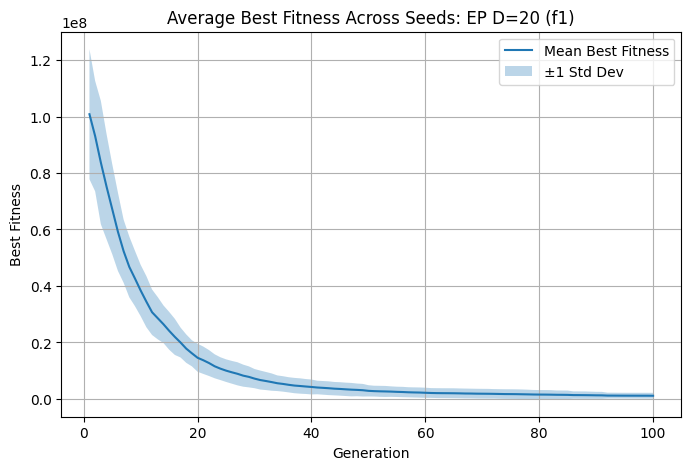

,Seed,Best Fitness
0,100,1.591829e+06
1,200,1.850081e+05
2,300,6.150571e+05
3,400,3.481949e+06
4,500,4.403113e+05
5,600,3.870293e+06
6,700,1.649761e+06
7,800,1.218338e+06
8,900,5.619856e+05
9,1000,6.032552e+05


In [13]:
seed_res = run_seed_EP(20, rosenbrock_fitness)
table_and_avg_plot(seed_res, title="EP D=20 (f1)")


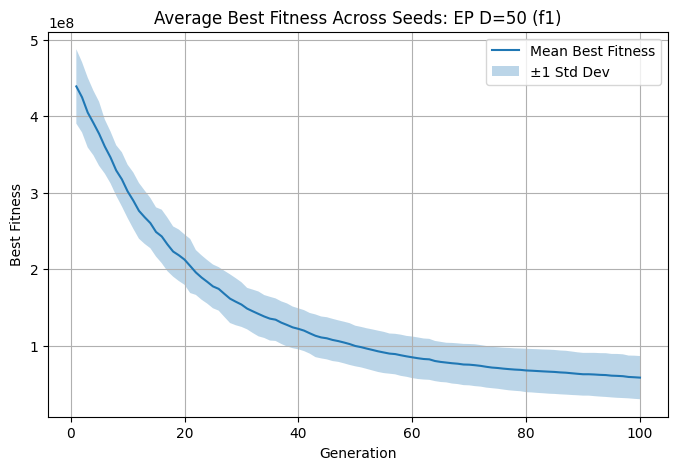

,Seed,Best Fitness
0,100,1.016101e+08
1,200,4.457749e+07
2,300,7.324026e+07
3,400,8.403448e+07
4,500,6.648967e+07
5,600,6.823666e+07
6,700,7.505876e+07
7,800,3.955656e+07
8,900,2.990404e+07
9,1000,6.110426e+07


In [14]:
seed_res = run_seed_EP(50, rosenbrock_fitness)
table_and_avg_plot(seed_res, title="EP D=50 (f1)")

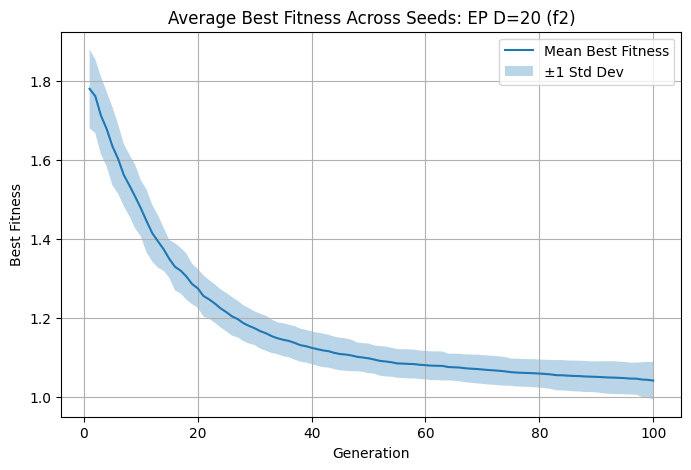

,Seed,Best Fitness
0,100,1.020006
1,200,1.033303
2,300,1.034792
3,400,1.086610
4,500,0.953765
5,600,1.044194
6,700,1.121812
7,800,1.043822
8,900,1.050454
9,1000,0.969621


In [15]:
seed_res = run_seed_EP(20, griewank_fitness)
table_and_avg_plot(seed_res, title="EP D=20 (f2)")

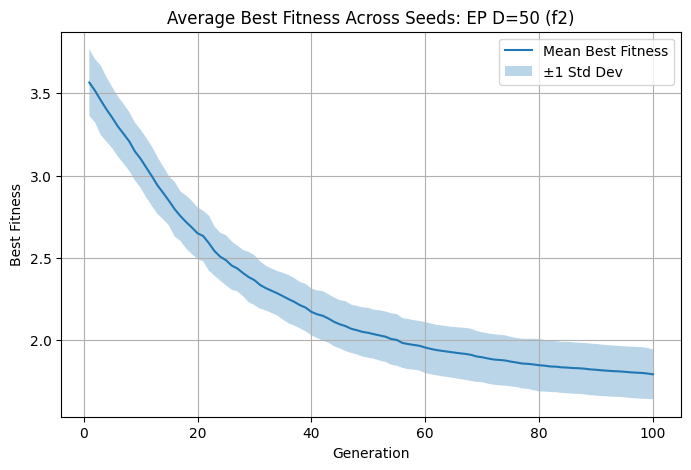

,Seed,Best Fitness
0,100,1.907698
1,200,1.757285
2,300,1.931300
3,400,1.829082
4,500,1.663327
5,600,1.800426
6,700,1.981147
7,800,1.835860
8,900,1.617167
9,1000,1.879227


In [16]:
seed_res = run_seed_EP(50, griewank_fitness)
table_and_avg_plot(seed_res, title="EP D=50 (f2)")

In [ ]:
def run_seed_ES(dimension,fitness):

    seeds = [i * 100 for i in range(1, 31)] 

    seed_res = []

    for seed in seeds:
        
        (logbook,hfa) = ES(dimension,fitness, 30, 100, -30, 30, 0.01, 0.1, seed=seed)

        seed_res.append({
            "seed":seed,
            "best_values": logbook.select("min")
        })

    return seed_res

/Users/biboy/Desktop/school/AIML426/AIML426-Ass2/venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/biboy/Desktop/school/AIML426/AIML426-Ass2/venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/biboy/Desktop/school/AIML426/AIML426-Ass2/venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Strategy' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it

Gen 1: {'avg': np.float64(1.1266150690872294), 'std': np.float64(0.006570287886656309), 'min': np.float64(1.118213877918965), 'max': np.float64(1.1351763986243515)}
Gen 2: {'avg': np.float64(1.0563919343569494), 'std': np.float64(2.220446049250313e-16), 'min': np.float64(1.0563919343569497), 'max': np.float64(1.0563919343569497)}
Gen 3: {'avg': np.float64(1.0559598887337664), 'std': np.float64(2.220446049250313e-16), 'min': np.float64(1.0559598887337662), 'max': np.float64(1.0559598887337662)}
Gen 4: {'avg': np.float64(1.0563959209782765), 'std': np.float64(4.440892098500626e-16), 'min': np.float64(1.056395920978277), 'max': np.float64(1.056395920978277)}
Gen 5: {'avg': np.float64(1.0558396319849281), 'std': np.float64(2.220446049250313e-16), 'min': np.float64(1.0558396319849284), 'max': np.float64(1.0558396319849284)}
Gen 6: {'avg': np.float64(1.0540843353420035), 'std': np.float64(2.220446049250313e-16), 'min': np.float64(1.0540843353420033), 'max': np.float64(1.0540843353420033)}
Ge

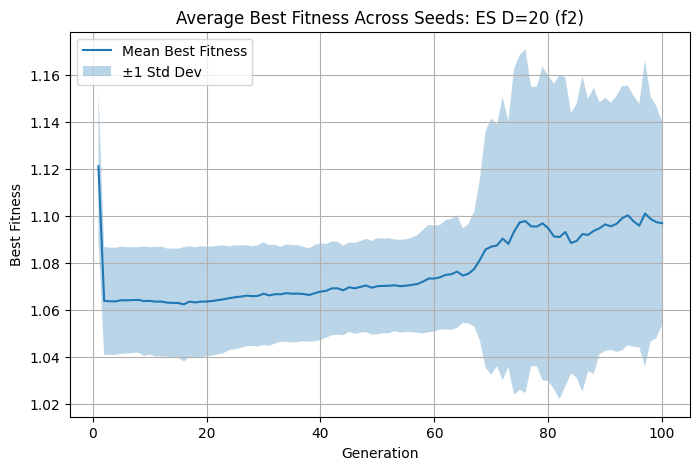

,Seed,Best Fitness
0,100,1.075805
1,200,1.088141
2,300,1.138286
3,400,1.109852
4,500,1.070589
5,600,1.117971
6,700,1.058323
7,800,1.124068
8,900,1.127628
9,1000,1.059327


In [58]:
seed_res = run_seed_ES(20, griewank_fitness)
table_and_avg_plot(seed_res, title="ES D=20 (f2)")

/Users/biboy/Desktop/school/AIML426/AIML426-Ass2/venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/biboy/Desktop/school/AIML426/AIML426-Ass2/venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/biboy/Desktop/school/AIML426/AIML426-Ass2/venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Strategy' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it

Gen 1: {'avg': np.float64(2.5003962695726925), 'std': np.float64(0.16050654517163254), 'min': np.float64(2.2718520878422597), 'max': np.float64(2.8219750344444336)}
Gen 2: {'avg': np.float64(1.325850135166438), 'std': np.float64(0.015116368398583773), 'min': np.float64(1.3030331167923752), 'max': np.float64(1.338659880986904)}
Gen 3: {'avg': np.float64(1.2005319879519474), 'std': np.float64(0.0006100580279502599), 'min': np.float64(1.2002461627803613), 'max': np.float64(1.2018340804002836)}
Gen 4: {'avg': np.float64(1.2002756726996286), 'std': np.float64(0.0), 'min': np.float64(1.2002756726996286), 'max': np.float64(1.2002756726996286)}
Gen 5: {'avg': np.float64(1.2020968910575764), 'std': np.float64(0.0), 'min': np.float64(1.2020968910575764), 'max': np.float64(1.2020968910575764)}
Gen 6: {'avg': np.float64(1.2028420158772999), 'std': np.float64(2.220446049250313e-16), 'min': np.float64(1.2028420158772997), 'max': np.float64(1.2028420158772997)}
Gen 7: {'avg': np.float64(1.20269495462

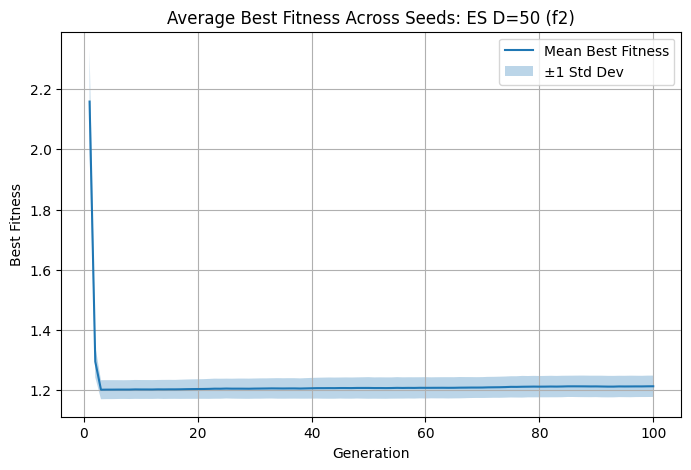

,Seed,Best Fitness
0,100,1.228023
1,200,1.213654
2,300,1.184392
3,400,1.155301
4,500,1.205299
5,600,1.211084
6,700,1.191570
7,800,1.265165
8,900,1.158712
9,1000,1.248167


In [52]:
seed_res = run_seed_ES(50, griewank_fitness)
table_and_avg_plot(seed_res, title="ES D=50 (f2)")

/Users/biboy/Desktop/school/AIML426/AIML426-Ass2/venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/biboy/Desktop/school/AIML426/AIML426-Ass2/venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/biboy/Desktop/school/AIML426/AIML426-Ass2/venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Strategy' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it

Gen 1: {'avg': np.float64(57751124.63941246), 'std': np.float64(16532777.08586941), 'min': np.float64(30461994.302595537), 'max': np.float64(85826926.73266418)}
Gen 2: {'avg': np.float64(4651004.926565239), 'std': np.float64(255092.03385823034), 'min': np.float64(4437939.470861561), 'max': np.float64(5173259.305114197)}
Gen 3: {'avg': np.float64(2466149.5385331674), 'std': np.float64(4617.199707043016), 'min': np.float64(2461713.476544138), 'max': np.float64(2470955.2723546154)}
Gen 4: {'avg': np.float64(2453411.657826122), 'std': np.float64(4.656612873077393e-10), 'min': np.float64(2453411.6578261214), 'max': np.float64(2453411.6578261214)}
Gen 5: {'avg': np.float64(2463354.9959372096), 'std': np.float64(4.656612873077393e-10), 'min': np.float64(2463354.995937209), 'max': np.float64(2463354.995937209)}
Gen 6: {'avg': np.float64(2447752.5129027013), 'std': np.float64(0.0), 'min': np.float64(2447752.5129027013), 'max': np.float64(2447752.5129027013)}
Gen 7: {'avg': np.float64(2451054.10

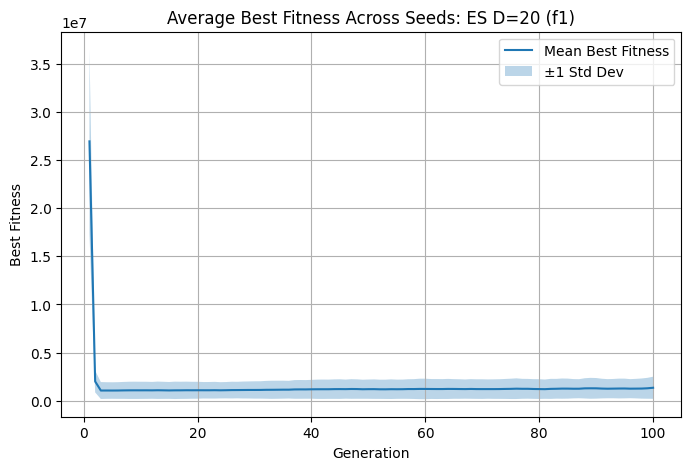

,Seed,Best Fitness
0,100,2.786273e+06
1,200,1.586016e+06
2,300,9.794153e+05
3,400,1.310765e+06
4,500,1.541202e+05
5,600,2.442165e+06
6,700,1.250491e+06
7,800,1.499236e+06
8,900,4.846687e+06
9,1000,4.072134e+05


In [53]:
seed_res = run_seed_ES(20, rosenbrock_fitness)
table_and_avg_plot(seed_res, title="ES D=20 (f1)")


/Users/biboy/Desktop/school/AIML426/AIML426-Ass2/venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/biboy/Desktop/school/AIML426/AIML426-Ass2/venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/biboy/Desktop/school/AIML426/AIML426-Ass2/venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Strategy' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it

Gen 1: {'avg': np.float64(168215768.41613665), 'std': np.float64(44740504.993367486), 'min': np.float64(119829398.31663682), 'max': np.float64(260750995.26670036)}
Gen 2: {'avg': np.float64(12084424.55967119), 'std': np.float64(2437417.426231197), 'min': np.float64(9383101.57680136), 'max': np.float64(16520941.399695205)}
Gen 3: {'avg': np.float64(2045675.485967557), 'std': np.float64(4696.365500748462), 'min': np.float64(2041998.7889513616), 'max': np.float64(2051674.3074150323)}
Gen 4: {'avg': np.float64(2016824.567652302), 'std': np.float64(2.3283064365386963e-10), 'min': np.float64(2016824.5676523023), 'max': np.float64(2016824.5676523023)}
Gen 5: {'avg': np.float64(2076345.9124749156), 'std': np.float64(0.0), 'min': np.float64(2076345.9124749156), 'max': np.float64(2076345.9124749156)}
Gen 6: {'avg': np.float64(2104715.5738953915), 'std': np.float64(0.0), 'min': np.float64(2104715.5738953915), 'max': np.float64(2104715.5738953915)}
Gen 7: {'avg': np.float64(2074839.353076548), 'st

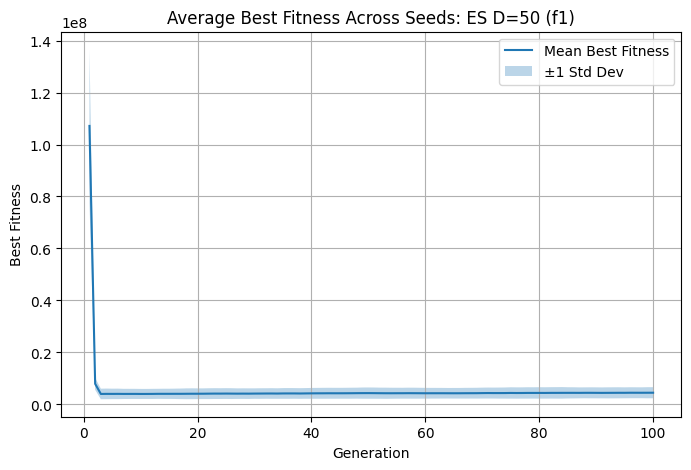

,Seed,Best Fitness
0,100,2.723706e+06
1,200,6.854763e+06
2,300,6.662266e+06
3,400,1.828721e+06
4,500,4.199063e+06
5,600,2.719817e+06
6,700,5.570860e+06
7,800,4.939960e+06
8,900,2.778168e+06
9,1000,3.813685e+06


In [54]:
seed_res = run_seed_ES(50, rosenbrock_fitness)
table_and_avg_plot(seed_res, title="ES D=50 (f1)")